## Imports

In [1]:
import sys
original_sys_path = sys.path.copy()
import random
import scipy as sc
from scipy import sparse

from fibrefunctions import *
from fibremodels import *
from fibredata import *

Files (42) imported from USB.
Files (189) imported from USB.


f:\venv code\Y4 Work\Optical Fibres\fibrefunctions.py:171: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


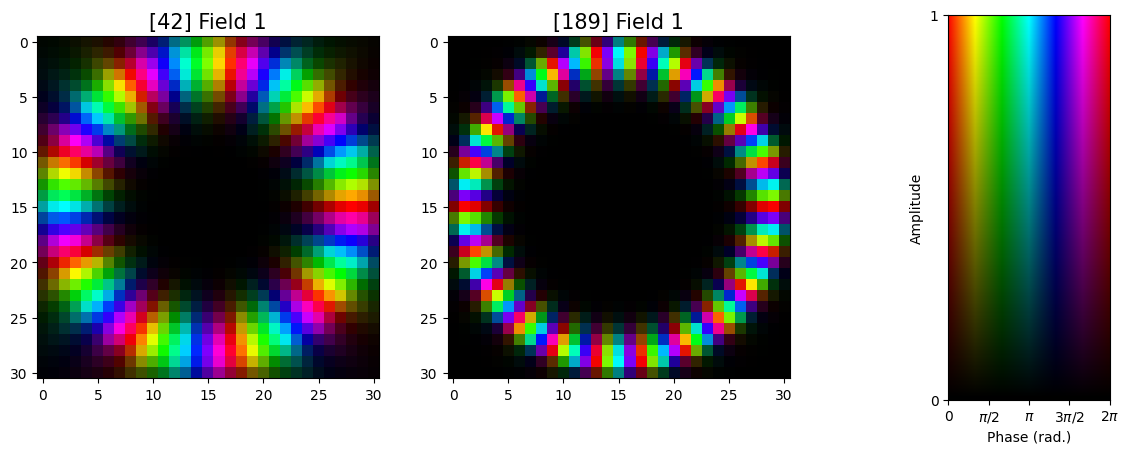

In [2]:
# Check imports and data is working correctly by plotting one of the fields
visualise2(PIMs_torch[0], PIMs_torch189[0], "", "[42] Field 1", "[189] Field 1")

# Fibre Model Work
Recently determined that the current fibre training model isn't good enough for practical use, due to the precision initial guesses are required to be made to. Before changing the optimisation strategy, try shrinking the propagation length between bends to make the slowest and fastest PIMs have a Pi phase difference (all other PIMs lying between the 2 extremes).

In [3]:
print(min(beta))
print(max(beta))
print(max(beta)-min(beta))

for i in range(len(beta)):
    if beta[i] == min(beta):
        print(i)

[14428457.374788]
[14461149.90083687]
[32692.52604887]
4
38


In [4]:
def d(v1, v2):
    return abs(1/(2*freq*(1/v2 - 1/v1)))

dist = d(min(beta_torch), max(beta_torch))
dist.item()

6.7379418979498155e-06

Avg phase diff: 3.1523185532574702

f:\venv code\Y4 Work\Optical Fibres\fibrefunctions.py:171: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()
f:\venv code\Y4 Work\Optical Fibres\fibrefunctions.py:171: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


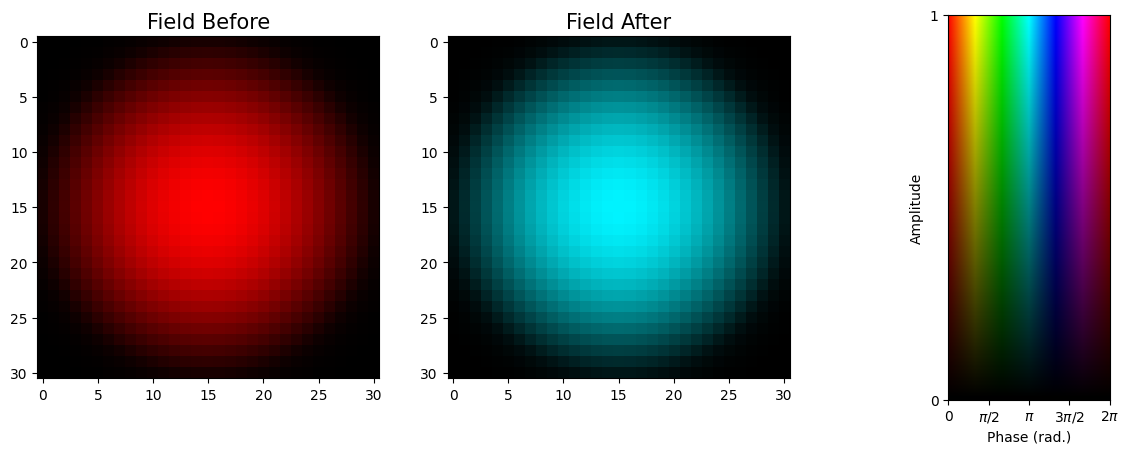

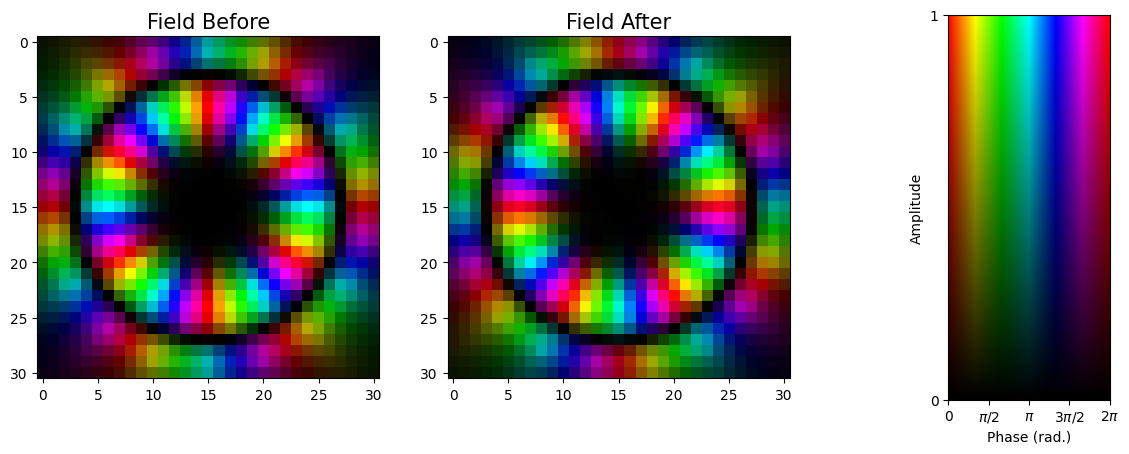

In [5]:
field_in_fast = PIMs_torch[19]
field_out_fast = propagate(field_in_fast, PIMs_torch, beta_torch, dist)
visualise2(field_in_fast, field_out_fast)
#print(f"Difference between fast fields:{loss_func_single(field_in_fast, field_out_fast)}")

field_in_slow = PIMs_torch[4]
field_out_slow = propagate(field_in_slow, PIMs_torch, beta_torch, dist)
visualise2(field_in_slow, field_out_slow)
#print(f"Difference between slow fields:{loss_func_single(field_in_slow, field_out_slow)}")

print(f"Avg phase diff: {abs(torch.angle(field_out_slow).sum().item()/31**2 - torch.angle(field_out_fast).sum().item()/31**2)}")

0

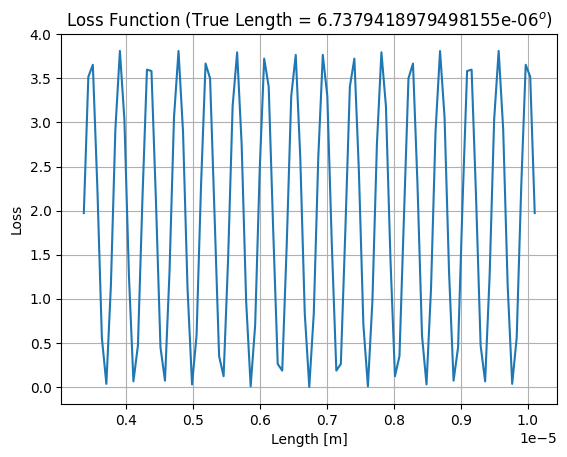

In [6]:
dist = 6.7379418979498155e-06
plot_loss_length(42, dist, dist/2, dist+dist/2, 101)

Try modelling a fibre with 50 bends (100 unknowns), with each tilt being less than 1 degree, see if, from initial guesses of 0, the model can find the correct parameters.

In [7]:
def rand_bends(n:int=1, l_bound:float=0, u_bound:float=1, precision:int=3):
    """Generates n number of bends with random angles (in degrees) between l_bound and u_bound."""
    bends = []
    for i in range(n):
        bends.append([round(random.uniform(l_bound, u_bound), precision), round(random.uniform(l_bound, u_bound), precision)])
    bends_arr = np.array(bends)
    return torch.from_numpy(bends_arr).to(dtype=torch.float32)
    

In [16]:
# Angles
#angles = np.array([[0.5,0.5],[0.4,0.3],[0,0.6]])
#angles = torch.from_numpy(angles).to(dtype=torch.float32)
angles = rand_bends(5)
# Model
model = BendModel(angles)

# Input fields
n = 10 # Number of fields
fields_in = PIMs_torch[:n]

# Make target fields
fields_target = []
for i in range(n):
    fields_target.append(model(fields_in[i]).detach())
fields_target = np.array(fields_target)
fields_target = torch.from_numpy(fields_target)

print(fields_in.shape)
print(fields_target.shape)

torch.Size([10, 31, 31])
torch.Size([10, 31, 31])


Epoch 0, Loss: 1.314498586356511, Bend 1: (0.009999996051192284, -0.009999997913837433), Bend 2: (0.009999998845160007, -0.009999995119869709), Bend 3: (0.009999998845160007, -0.009999995119869709)
Epoch 50, Loss: 0.8255130593783081, Bend 1: (0.37533774971961975, -0.1959388703107834), Bend 2: (0.14761972427368164, -0.4566759765148163), Bend 3: (0.20446258783340454, 0.4427972435951233)
Epoch 100, Loss: 0.6608267036569627, Bend 1: (0.48525547981262207, 0.0016436674632132053), Bend 2: (0.34849870204925537, -0.696735680103302), Bend 3: (-0.24813403189182281, 0.6841587424278259)
Epoch 150, Loss: 0.6099610377274896, Bend 1: (0.05314619094133377, -0.008213208988308907), Bend 2: (0.13778921961784363, -0.7039096355438232), Bend 3: (-0.38539281487464905, 0.5659016370773315)
Epoch 200, Loss: 0.5709396083121535, Bend 1: (-0.03375546261668205, -0.08187159895896912), Bend 2: (0.10889377444982529, -0.517288327217102), Bend 3: (-0.4282761514186859, 0.705004096031189)

Final Loss: 0.5477288381225064
Fi

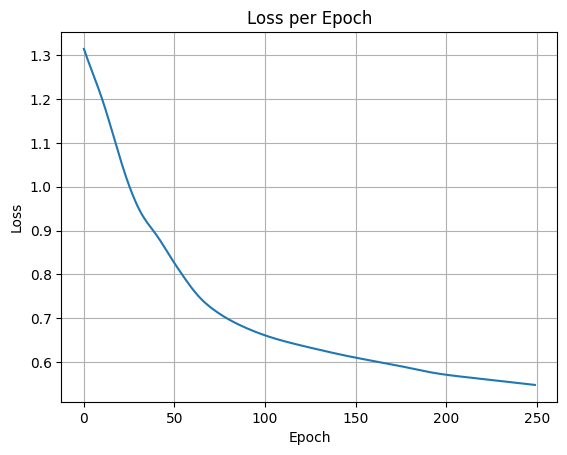

In [17]:
# Training loop
init_guesses = torch.zeros((10,2))
model = BendModel(init_guesses)#.to(device)
optimiser = torch.optim.Adam(model.parameters(), lr=1e-2)

epochs = 250
epoch_list = []
loss_list = []

for epoch in range(epochs):
    optimiser.zero_grad()
    
    # Make output data
    fields_out = []
    for k in range(n):
        fields_out.append(model(fields_in[k]))
    #fields_out = np.array(fields_out)
    #fields_out = torch.from_numpy(fields_out)

    # Compute loss
    loss = loss_func(fields_out, fields_target)
    # Backwards pass
    loss.backward()
    optimiser.step()

    epoch_list.append(epoch)
    loss_list.append(loss.detach().item())

    if epoch % 50 == 0:
        print(f"Epoch {epoch}, Loss: {loss.item()}, Bend 1: {model.angles[0,0].item(), model.angles[0,1].item()}, Bend 2: {model.angles[1,0].item(), model.angles[1,1].item()}, Bend 3: {model.angles[2,0].item(), model.angles[2,1].item()}")

print(f"\nFinal Loss: {loss.item()}")
print(f"Final Bend 1: {model.angles[0,0].item(), model.angles[0,1].item()}")
print(f"Final Bend 2: {model.angles[1,0].item(), model.angles[1,1].item()}")
print(f"Final Bend 3: {model.angles[2,0].item(), model.angles[2,1].item()}")

plt.plot(epoch_list, loss_list)
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Loss per Epoch")
plt.grid(visible=True)

# Sparse Matrices

In [10]:
A = torch.tensor([[1,0,0],[0,2,0],[0,1,3]]).to_sparse()
B = torch.tensor([[1],[2],[3]])

A @ B

tensor([[ 1],
        [ 4],
        [11]])

In [11]:
def beta_matrix_test(beta_torch, length=0):
    """Function to make the diagonal square matrix for PIM propagation in an MMF."""
    return torch.diag(torch.exp(1j*length*beta_torch.flatten())).to_sparse()

def TM_test(PIMs_torch, beta_torch, length=0):
    """Creates the transmission matrix for a MMF, assumed to be perfectly straight,
    of length=length."""
    TM_part1 = beta_matrix_test(beta_torch, length) @ pim_matrix(PIMs_torch)
    TM = real_matrix(PIMs_torch) @ TM_part1
    return TM.to_sparse()

def propagate_test(field, PIMs_torch, beta_torch, length=0):
    """Function to propagate an input field through a segment of perfectly
    straight optical fibre of length=length."""
    field_vec = vectorise(field)
    field_out_vec = TM_test(PIMs_torch, beta_torch, length) @ field_vec
    field_out = unvectorise(field_out_vec, 31)
    return field_out

f:\venv code\Y4 Work\Optical Fibres\fibrefunctions.py:171: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


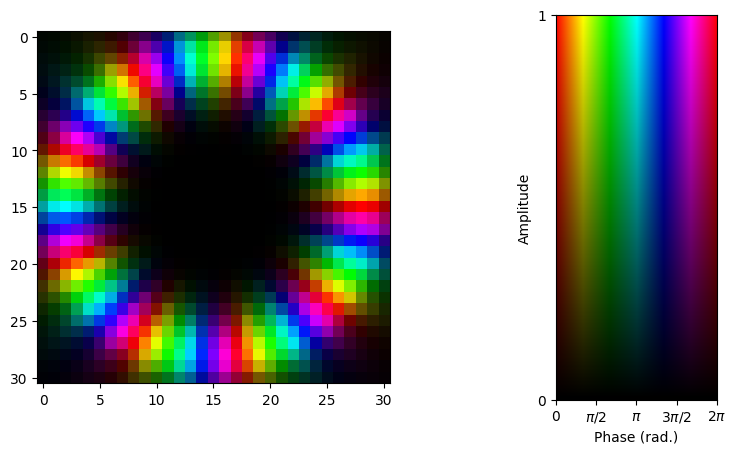

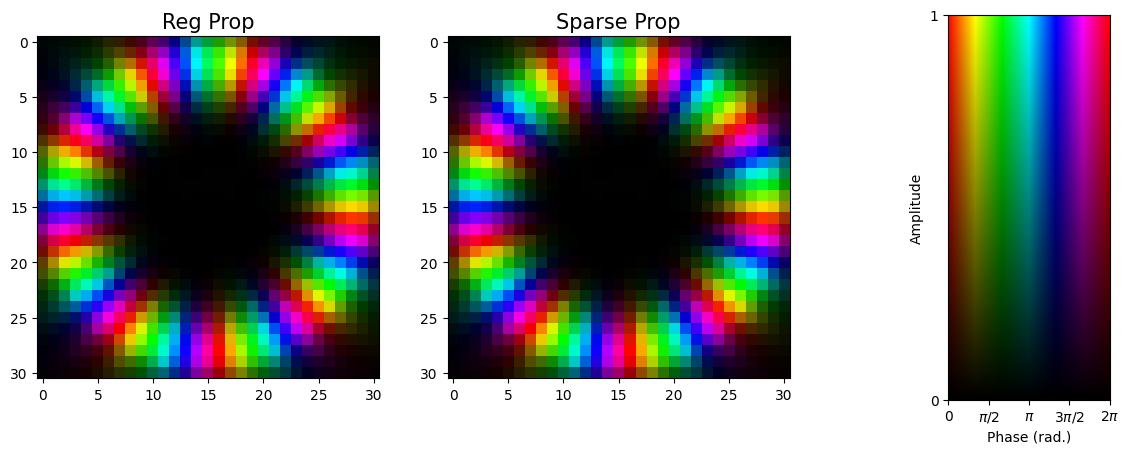

In [12]:
field_in_test = PIMs_torch[0]
test_field1 = propagate(field_in_test, PIMs_torch, beta_torch, 0.1)
test_field2 = propagate_test(field_in_test, PIMs_torch, beta_torch, 0.1)

visualise(PIMs_torch[0])
visualise2(test_field1, test_field2,"","Reg Prop", "Sparse Prop")

# Calculating loss differently

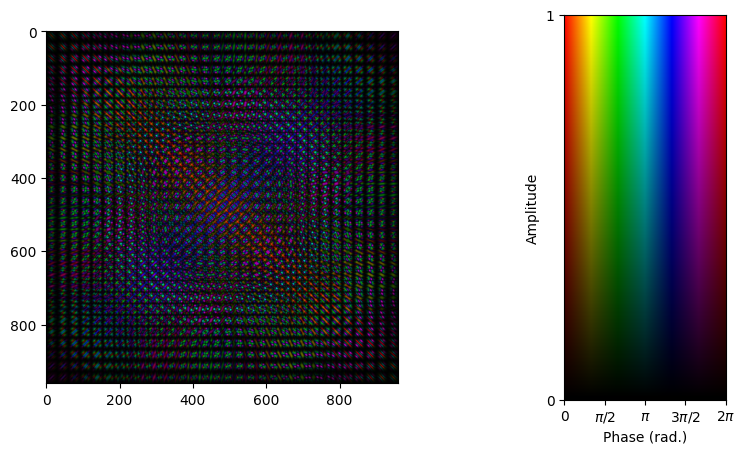

In [24]:
pim_mat = pim_matrix(PIMs_torch)
real_mat = real_matrix(PIMs_torch)
b_mat = beta_matrix(beta_torch, 0.2)
bend_vec_x = vectorise(zernike_array('x',torch.tensor([0.5])))
bend_vec_y = vectorise(zernike_array('y', torch.tensor([0.3])))
bend_diag_x = torch.diag(bend_vec_x.T[0])
bend_diag_y = torch.diag(bend_vec_y.T[0])

test_mat = (real_mat @ (b_mat @ pim_mat))

visualise(test_mat)

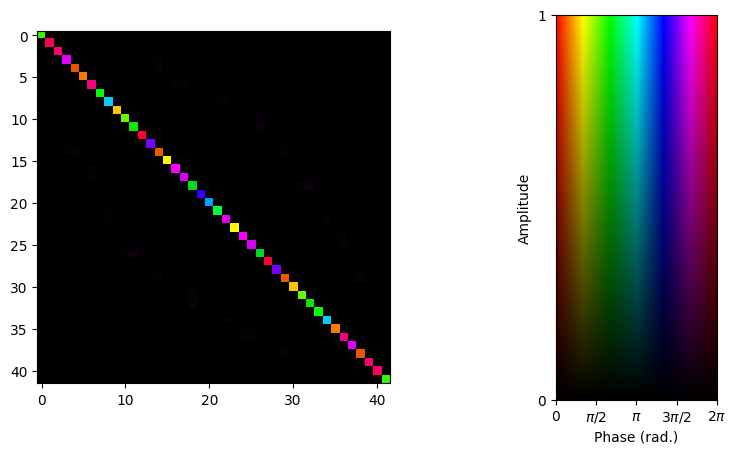

In [25]:
# TM in PIM basis
test_pim_mat = pim_mat @ test_mat @ real_mat
visualise(test_pim_mat)

In [19]:
pim_mat = pim_matrix(PIMs_torch)
real_mat = real_matrix(PIMs_torch)
b_mat = beta_matrix(beta_torch, 0.1)
bend_vec_x = vectorise(zernike_array('x',torch.tensor([0.5])))
bend_vec_y = vectorise(zernike_array('y', torch.tensor([0.3])))
bend_diag_x = torch.diag(bend_vec_x.T[0])
bend_diag_y = torch.diag(bend_vec_y.T[0])

test_mat = (real_mat @ (b_mat @ pim_mat)) @ ((bend_diag_y @ bend_diag_x) @ (real_mat @ (b_mat @ pim_mat)))

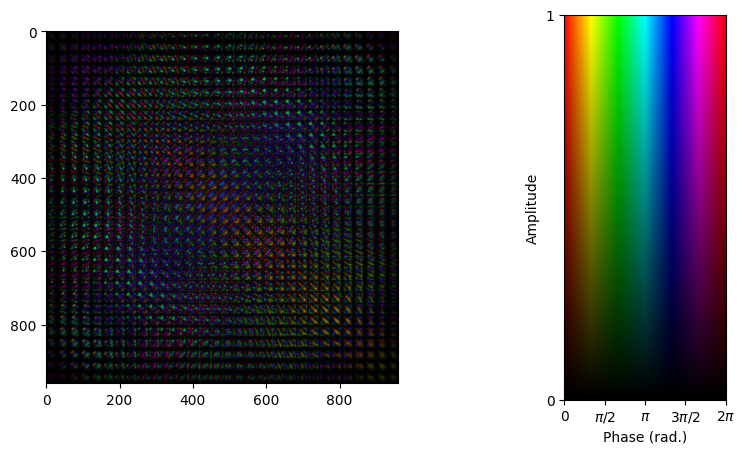

In [20]:
visualise(test_mat)

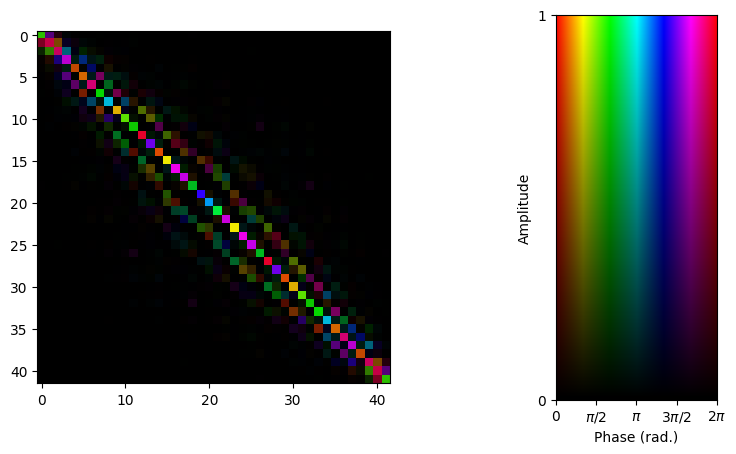

In [21]:
# TM in PIM basis
test_pim_mat = pim_mat @ test_mat @ real_mat
visualise(test_pim_mat)

f:\venv code\Y4 Work\Optical Fibres\fibrefunctions.py:171: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()
f:\venv code\Y4 Work\Optical Fibres\fibrefunctions.py:171: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


tensor(1.8846e-12, dtype=torch.float64)

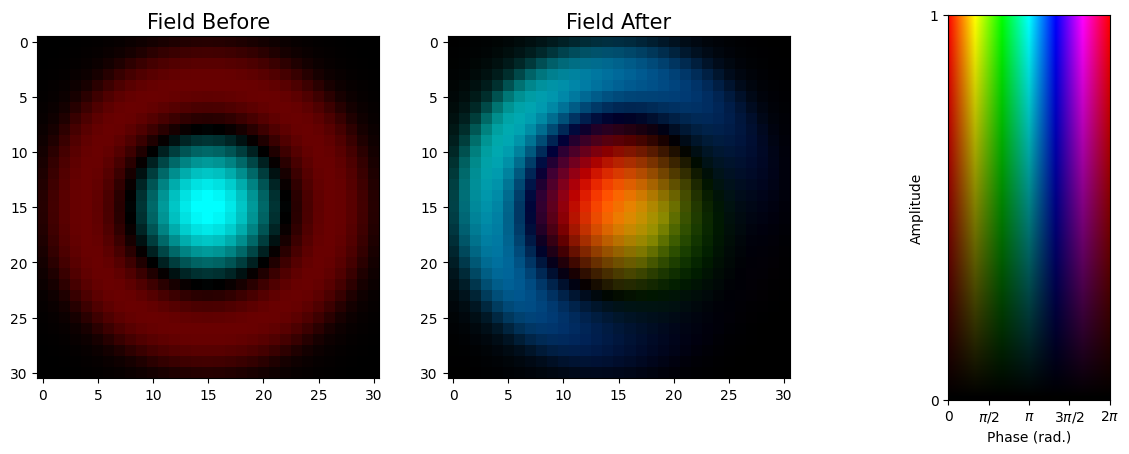

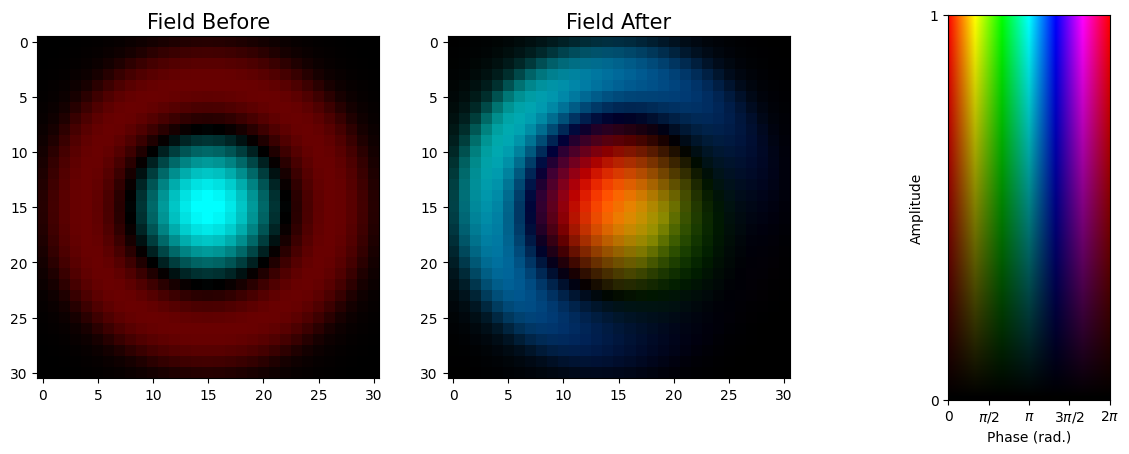

In [15]:
# Model test
field_in = PIMs_torch[20]

angles = torch.from_numpy(np.array([[0.5,0.3]]))
model = BendModel(angles)

target_out = model(field_in).detach()
visualise2(field_in, target_out)

# =======================================================================
# TM Test
field_out = unvectorise(test_mat @ vectorise(field_in), 31)
visualise2(field_in, field_out)

loss_func_single(field_out, target_out)